In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style untuk visualisasi
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [3]:
# Konfigurasi plot
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [5]:
# Load data
df = pd.read_csv('dataset.csv')

In [8]:
# Basic information
print("\nInfo:")
display(df.info())
print("\nFirst 5 rows:")
df.head()


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269260 entries, 0 to 269259
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           269260 non-null  int64  
 1   satuan       0 non-null       float64
 2   pasar        269260 non-null  int64  
 3   tanggal      269260 non-null  object 
 4   nama_item    269260 non-null  int64  
 5   keterangan   269260 non-null  object 
 6   harga        269260 non-null  int64  
 7   jumlah       269260 non-null  int64  
 8   kebutuhan    269260 non-null  int64  
 9   item_barang  269260 non-null  object 
 10  satuan_item  269259 non-null  object 
 11  nama_pasar   269259 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.7+ MB


None


First 5 rows:


,id,satuan,pasar,tanggal,nama_item,keterangan,harga,jumlah,kebutuhan,item_barang,satuan_item,nama_pasar
0,26766,NaN,7,2022-01-01,1,cukup,12000,0,0,Beras Premium,kg,Pasar Parakanmuncang
1,26767,NaN,7,2022-01-01,2,cukup,11500,0,0,Beras Medium,kg,Pasar Parakanmuncang
2,26768,NaN,7,2022-01-01,3,cukup,12000,0,0,Beras Termahal,kg,Pasar Parakanmuncang
3,26769,NaN,7,2022-01-01,4,cukup,14000,0,0,Gula Pasir,kg,Pasar Parakanmuncang
4,26770,NaN,7,2022-01-01,8,cukup,3000,0,0,Minyak Goreng Bimoli,liter,Pasar Parakanmuncang


In [9]:
# Data info lebih detail
print("Missing Values:")
print(df.isnull().sum())
print("\nUnique Values:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

Missing Values:
id                  0
satuan         269260
pasar               0
tanggal             0
nama_item           0
keterangan          0
harga               0
jumlah              0
kebutuhan           0
item_barang         0
satuan_item         1
nama_pasar          1
dtype: int64

Unique Values:
id: 269260
satuan: 0
pasar: 9
tanggal: 1021
nama_item: 73
keterangan: 24
harga: 200
jumlah: 751
kebutuhan: 1108
item_barang: 72
satuan_item: 13
nama_pasar: 9


In [10]:
# Data cleaning pipeline
def clean_data(df):
    """
    Membersihkan data sesuai dengan kebutuhan analisis
    """
    # Filter hanya data dengan satuan kg
    df_clean = df[df['satuan_item'] == 'kg'].copy()

    # Convert tanggal ke datetime
    df_clean['tanggal'] = pd.to_datetime(df_clean['tanggal'], errors='coerce')

    # Extract tahun dan bulan
    df_clean['tahun'] = df_clean['tanggal'].dt.year
    df_clean['bulan'] = df_clean['tanggal'].dt.month
    df_clean['hari'] = df_clean['tanggal'].dt.day
    df_clean['day_of_week'] = df_clean['tanggal'].dt.dayofweek

    # Drop missing values
    df_clean = df_clean.dropna(subset=['jumlah', 'kebutuhan', 'tanggal'])

    # Convert to numeric
    df_clean['jumlah'] = pd.to_numeric(df_clean['jumlah'], errors='coerce')
    df_clean['kebutuhan'] = pd.to_numeric(df_clean['kebutuhan'], errors='coerce')

    # Remove outliers menggunakan IQR
    def remove_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    df_clean = remove_outliers(df_clean, 'jumlah')
    df_clean = remove_outliers(df_clean, 'kebutuhan')

    return df_clean

In [11]:
# Apply cleaning
df_clean = clean_data(df)
print(f"Data setelah cleaning: {df_clean.shape[0]} rows")
print(f"Data yang dihapus: {df.shape[0] - df_clean.shape[0]} rows ({((df.shape[0] - df_clean.shape[0]) / df.shape[0] * 100):.1f}%)")

Data setelah cleaning: 128487 rows
Data yang dihapus: 140773 rows (52.3%)


In [12]:
# Basic statistics
print("Statistik Deskriptif:")
print(df_clean[['jumlah', 'kebutuhan']].describe())

Statistik Deskriptif:
              jumlah      kebutuhan
count  128487.000000  128487.000000
mean       12.523749       7.404126
std        27.180325      15.271620
min         0.000000       0.000000
25%         0.000000       0.000000
50%         0.000000       0.000000
75%        10.000000       5.000000
max       320.000000      67.000000


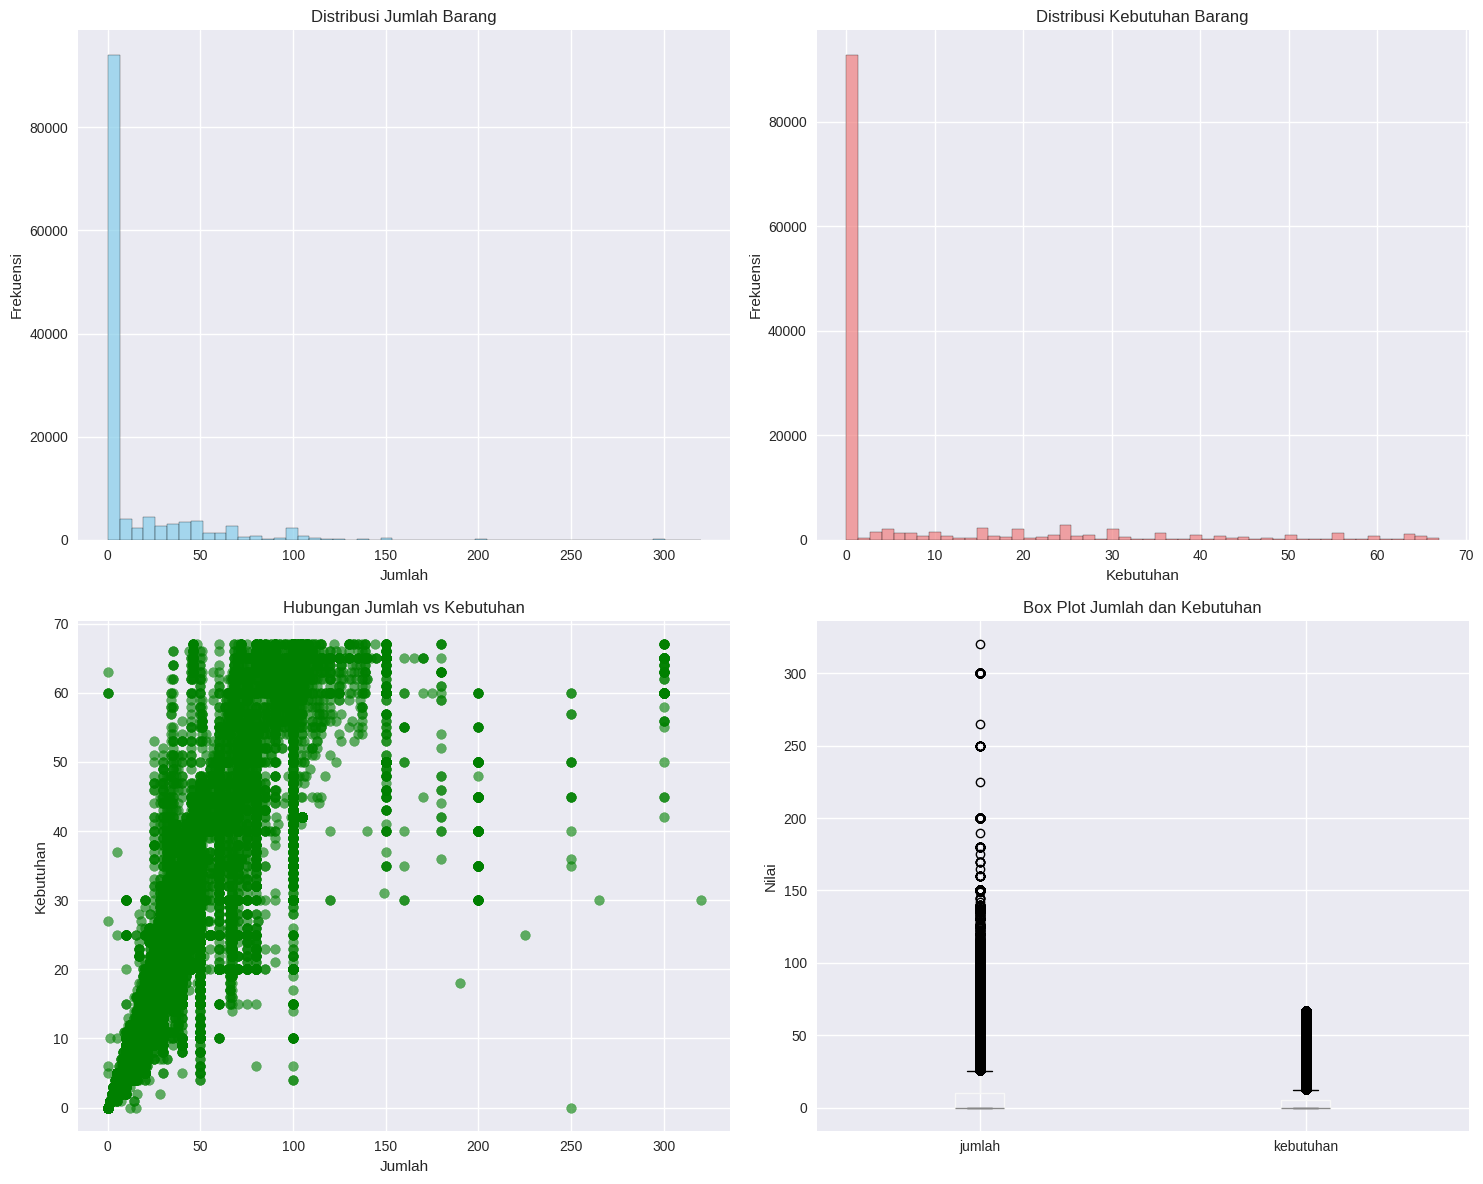

In [15]:
# Visualisasi distribusi
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribusi jumlah
axes[0,0].hist(df_clean['jumlah'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribusi Jumlah Barang')
axes[0,0].set_xlabel('Jumlah')
axes[0,0].set_ylabel('Frekuensi')

# Distribusi kebutuhan
axes[0,1].hist(df_clean['kebutuhan'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Distribusi Kebutuhan Barang')
axes[0,1].set_xlabel('Kebutuhan')
axes[0,1].set_ylabel('Frekuensi')

# Scatter plot jumlah vs kebutuhan
axes[1,0].scatter(df_clean['jumlah'], df_clean['kebutuhan'], alpha=0.6, color='green')
axes[1,0].set_title('Hubungan Jumlah vs Kebutuhan')
axes[1,0].set_xlabel('Jumlah')
axes[1,0].set_ylabel('Kebutuhan')

# Box plot
df_clean[['jumlah', 'kebutuhan']].boxplot(ax=axes[1,1])
axes[1,1].set_title('Box Plot Jumlah dan Kebutuhan')
axes[1,1].set_ylabel('Nilai')

plt.tight_layout()
plt.show()

Korelasi antara Jumlah dan Kebutuhan: 0.911


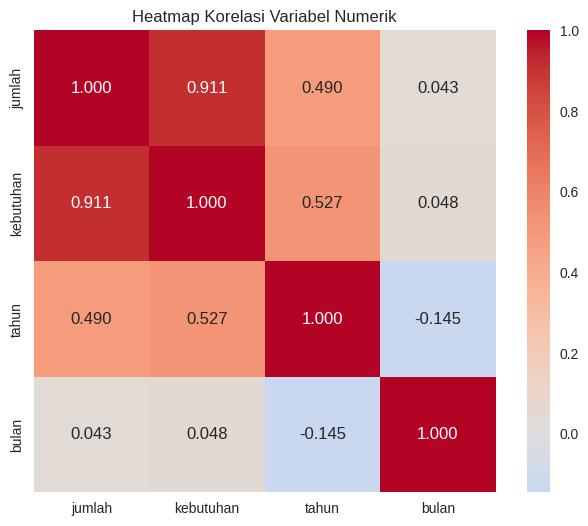

In [16]:
# Korelasi analysis
correlation = df_clean['jumlah'].corr(df_clean['kebutuhan'])
print(f"Korelasi antara Jumlah dan Kebutuhan: {correlation:.3f}")

# Heatmap korelasi
plt.figure(figsize=(8, 6))
corr_matrix = df_clean[['jumlah', 'kebutuhan', 'tahun', 'bulan']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Heatmap Korelasi Variabel Numerik')
plt.show()

In [17]:
# Analisis berdasarkan pasar
pasar_analysis = df_clean.groupby('nama_pasar').agg({
    'jumlah': ['mean', 'std', 'count'],
    'kebutuhan': ['mean', 'std', 'count']
}).round(2)

print("Analisis per Pasar:")
print(pasar_analysis)

Analisis per Pasar:
                     jumlah               kebutuhan              
                       mean    std  count      mean    std  count
nama_pasar                                                       
Pasar Buahdua         21.83  30.22  13220     11.70  13.31  13220
Pasar Conggeang       25.18  37.04  13829     14.82  21.76  13829
Pasar Darmaraja       15.47  26.39  15574      7.55  12.57  15574
Pasar Inpres           2.63  22.44  16617      0.78   5.67  16617
Pasar Parakanmuncang   5.74  16.66  16353      4.42  11.61  16353
Pasar Situraja         5.36  18.11  10467      3.92  12.04  10467
Pasar Tanjungsari     12.75  29.45  13308      9.09  20.75  13308
Pasar Ujungjaya        8.56  18.60  11422      6.07  13.28  11422
Pasar Wado            15.27  28.60  17697      8.91  15.97  17697


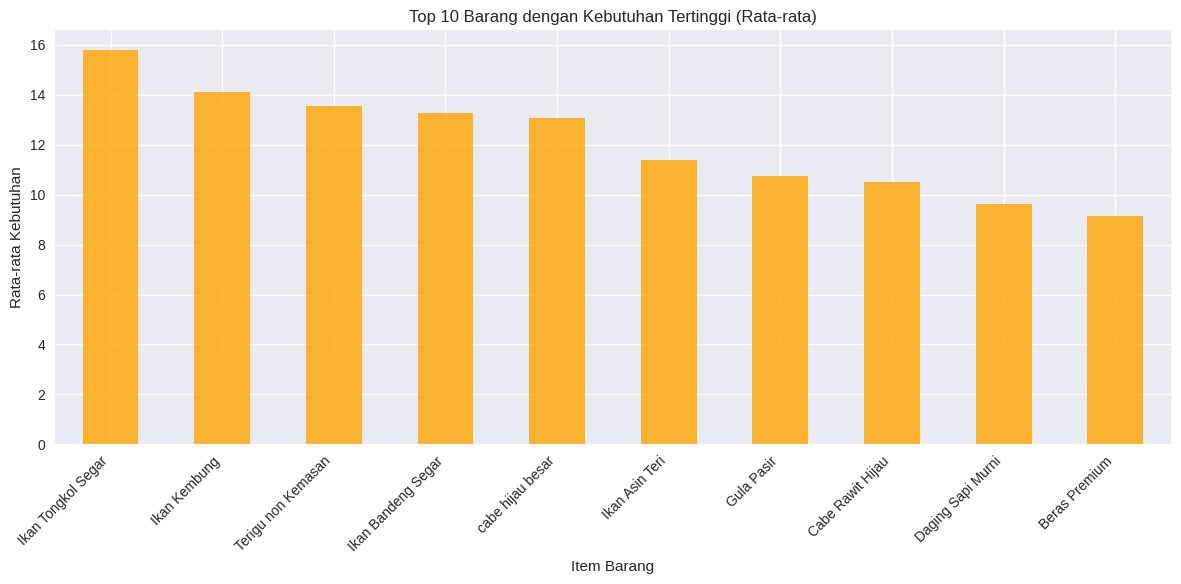

In [18]:
# Top 10 barang dengan kebutuhan tertinggi
top_items = df_clean.groupby('item_barang')['kebutuhan'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_items.plot(kind='bar', color='orange', alpha=0.8)
plt.title('Top 10 Barang dengan Kebutuhan Tertinggi (Rata-rata)')
plt.xlabel('Item Barang')
plt.ylabel('Rata-rata Kebutuhan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [19]:
# Prepare features untuk clustering
def prepare_clustering_features(df):
    """
    Mempersiapkan features untuk clustering
    """
    # Agregasi data per kombinasi pasar dan item
    features = df.groupby(['nama_pasar', 'item_barang']).agg({
        'jumlah': ['mean', 'std', 'min', 'max'],
        'kebutuhan': ['mean', 'std', 'min', 'max'],
        'tanggal': 'count'  # frequency
    }).round(2)

    # Flatten column names
    features.columns = ['_'.join(col).strip() for col in features.columns]
    features = features.rename(columns={'tanggal_count': 'frequency'})

    # Fill NaN dengan 0 untuk std
    features = features.fillna(0)

    # Reset index
    features = features.reset_index()

    return features

In [20]:
# Create features
features_df = prepare_clustering_features(df_clean)
print(f"Features shape: {features_df.shape}")
print("\nFeatures columns:")
for i, col in enumerate(features_df.columns):
    print(f"{i+1}. {col}")

Features shape: (268, 11)

Features columns:
1. nama_pasar
2. item_barang
3. jumlah_mean
4. jumlah_std
5. jumlah_min
6. jumlah_max
7. kebutuhan_mean
8. kebutuhan_std
9. kebutuhan_min
10. kebutuhan_max
11. frequency


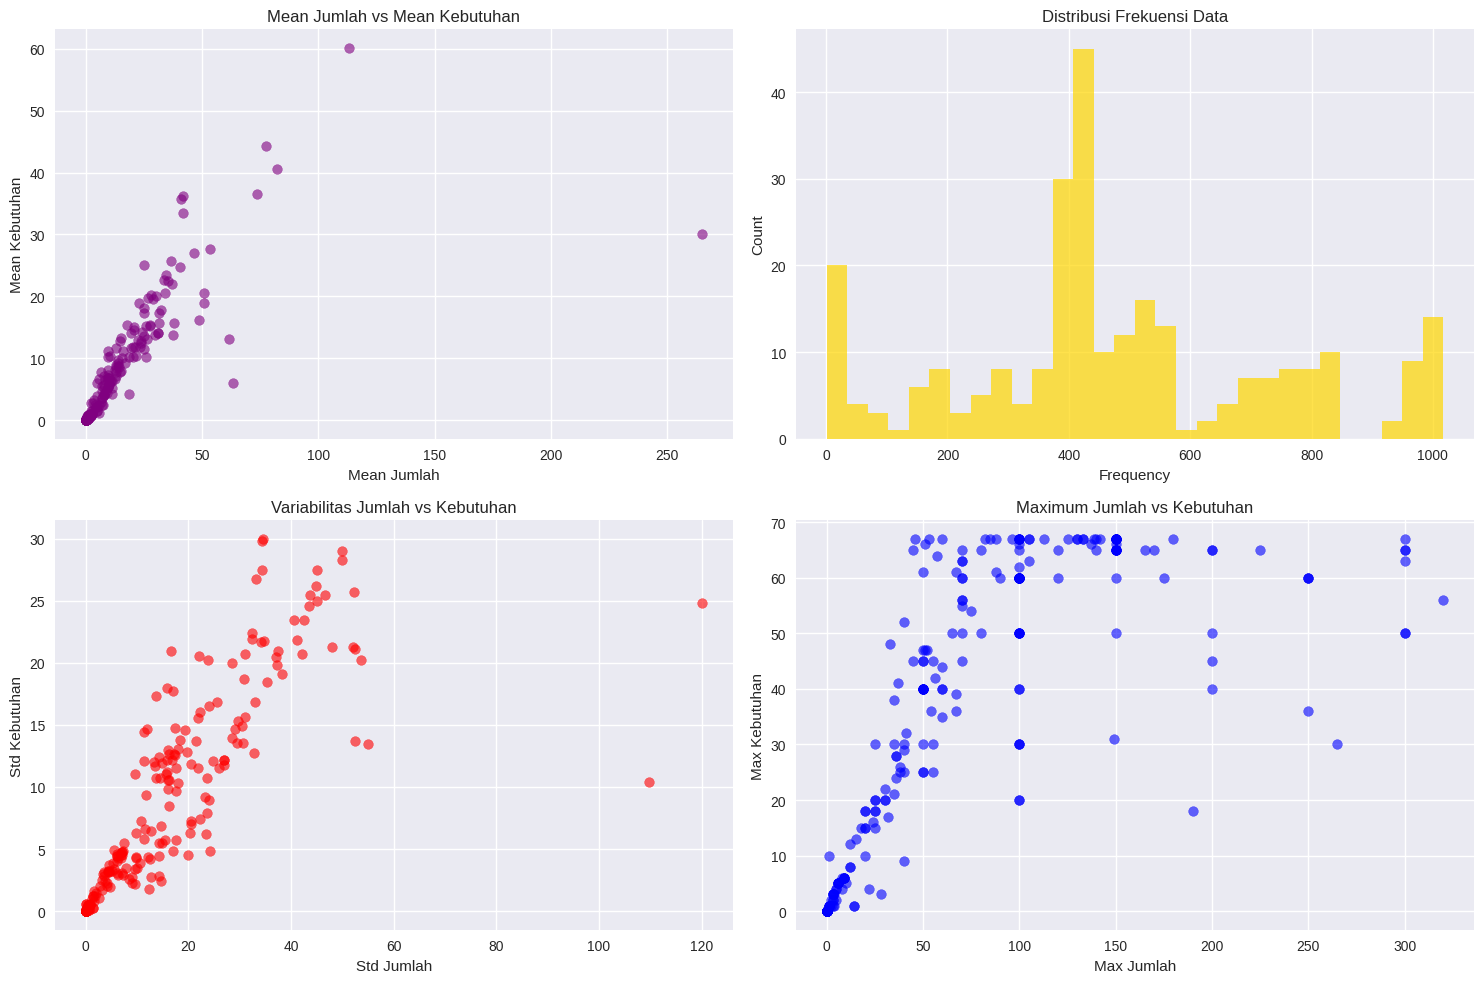

In [21]:
# Visualisasi features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Mean jumlah vs mean kebutuhan
axes[0,0].scatter(features_df['jumlah_mean'], features_df['kebutuhan_mean'],
                  alpha=0.6, color='purple')
axes[0,0].set_xlabel('Mean Jumlah')
axes[0,0].set_ylabel('Mean Kebutuhan')
axes[0,0].set_title('Mean Jumlah vs Mean Kebutuhan')

# Frequency distribution
axes[0,1].hist(features_df['frequency'], bins=30, alpha=0.7, color='gold')
axes[0,1].set_xlabel('Frequency')
axes[0,1].set_ylabel('Count')
axes[0,1].set_title('Distribusi Frekuensi Data')

# Std jumlah vs std kebutuhan
axes[1,0].scatter(features_df['jumlah_std'], features_df['kebutuhan_std'],
                  alpha=0.6, color='red')
axes[1,0].set_xlabel('Std Jumlah')
axes[1,0].set_ylabel('Std Kebutuhan')
axes[1,0].set_title('Variabilitas Jumlah vs Kebutuhan')

# Max jumlah vs max kebutuhan
axes[1,1].scatter(features_df['jumlah_max'], features_df['kebutuhan_max'],
                  alpha=0.6, color='blue')
axes[1,1].set_xlabel('Max Jumlah')
axes[1,1].set_ylabel('Max Kebutuhan')
axes[1,1].set_title('Maximum Jumlah vs Kebutuhan')

plt.tight_layout()
plt.show()

In [22]:
# Prepare data untuk clustering
X = features_df[['jumlah_mean', 'kebutuhan_mean']].copy()

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Data shape untuk clustering: {X_scaled.shape}")
print(f"Features yang digunakan: {X.columns.tolist()}")

Data shape untuk clustering: (268, 2)
Features yang digunakan: ['jumlah_mean', 'kebutuhan_mean']


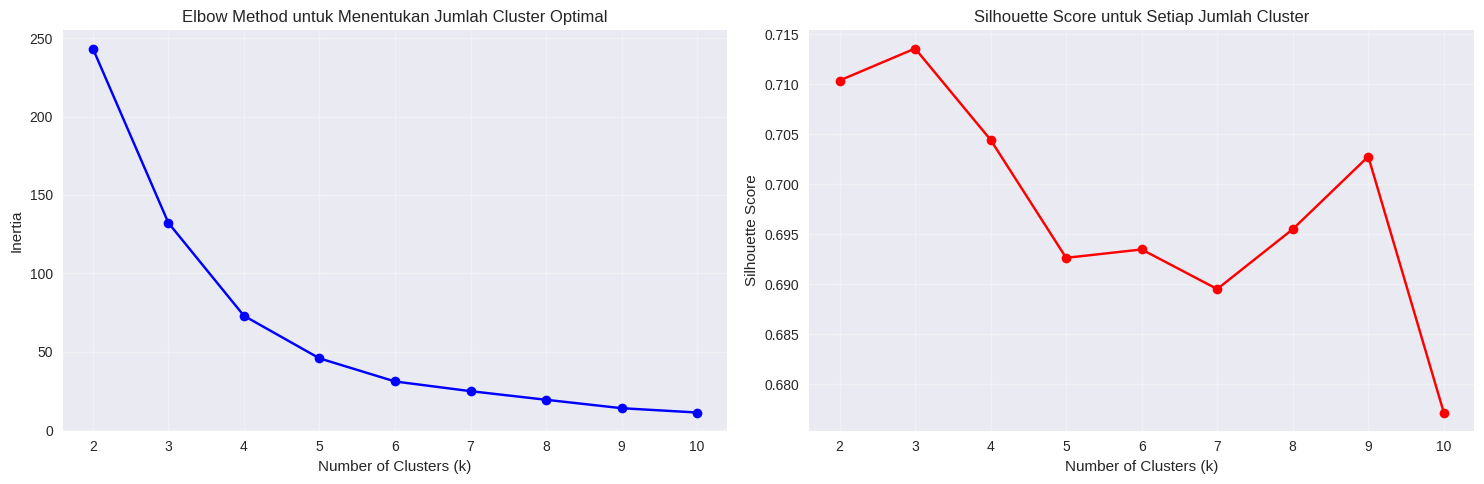

In [23]:
# Menentukan jumlah cluster optimal menggunakan Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow Method dan Silhouette Score
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method untuk Menentukan Jumlah Cluster Optimal')
ax1.grid(True, alpha=0.3)

# Silhouette Score
ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score untuk Setiap Jumlah Cluster')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
# Print scores
print("Silhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.3f}")

Silhouette Scores:
k=2: 0.710
k=3: 0.714
k=4: 0.704
k=5: 0.693
k=6: 0.693
k=7: 0.690
k=8: 0.696
k=9: 0.703
k=10: 0.677


In [25]:
# Pilih jumlah cluster optimal (berdasarkan silhouette score tertinggi)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Jumlah cluster optimal: {optimal_k}")
print(f"Silhouette score terbaik: {max(silhouette_scores):.3f}")

Jumlah cluster optimal: 3
Silhouette score terbaik: 0.714


In [26]:
# Fitting K-Means dengan jumlah cluster optimal
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans_optimal.fit_predict(X_scaled)

# Tambahkan cluster labels ke dataframe
features_df['cluster'] = clusters

# Cluster centers (dalam skala asli)
centers_scaled = kmeans_optimal.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

print(f"Cluster centers (skala asli):")
for i, center in enumerate(centers_original):
    print(f"Cluster {i}: Jumlah={center[0]:.2f}, Kebutuhan={center[1]:.2f}")

Cluster centers (skala asli):
Cluster 0: Jumlah=3.10, Kebutuhan=1.88
Cluster 1: Jumlah=30.04, Kebutuhan=16.99
Cluster 2: Jumlah=122.30, Kebutuhan=42.29


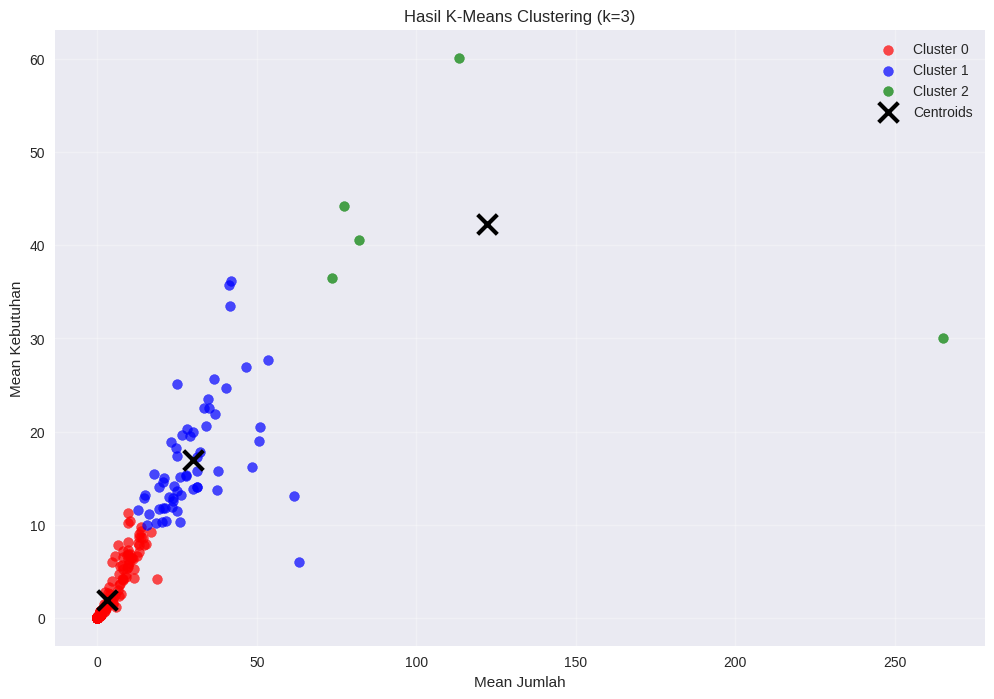

In [27]:
# Visualisasi cluster
plt.figure(figsize=(12, 8))

# Scatter plot dengan warna berbeda untuk setiap cluster
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
for i in range(optimal_k):
    cluster_data = features_df[features_df['cluster'] == i]
    plt.scatter(cluster_data['jumlah_mean'], cluster_data['kebutuhan_mean'],
                c=colors[i], label=f'Cluster {i}', alpha=0.7, s=50)

# Plot cluster centers
plt.scatter(centers_original[:, 0], centers_original[:, 1],
            c='black', marker='x', s=200, linewidths=3, label='Centroids')

plt.xlabel('Mean Jumlah')
plt.ylabel('Mean Kebutuhan')
plt.title(f'Hasil K-Means Clustering (k={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [28]:
# Visualisasi dengan Plotly (interaktif)
fig = px.scatter(features_df,
                 x='jumlah_mean',
                 y='kebutuhan_mean',
                 color=features_df['cluster'].astype(str),
                 hover_data=['nama_pasar', 'item_barang', 'frequency'],
                 title=f'Hasil K-Means Clustering (k={optimal_k}) - Interaktif',
                 labels={'jumlah_mean': 'Mean Jumlah',
                         'kebutuhan_mean': 'Mean Kebutuhan',
                         'color': 'Cluster'})

# Tambahkan cluster centers
fig.add_trace(go.Scatter(x=centers_original[:, 0],
                         y=centers_original[:, 1],
                         mode='markers',
                         marker=dict(color='black', size=15, symbol='x'),
                         name='Centroids'))

fig.show()

In [29]:
def analyze_clusters(df_with_clusters):
    """
    Menganalisis karakteristik setiap cluster
    """
    cluster_analysis = []

    for cluster_id in sorted(df_with_clusters['cluster'].unique()):
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]

        analysis = {
            'cluster_id': cluster_id,
            'count': len(cluster_data),
            'avg_jumlah': cluster_data['jumlah_mean'].mean(),
            'avg_kebutuhan': cluster_data['kebutuhan_mean'].mean(),
            'avg_frequency': cluster_data['frequency'].mean(),
            'top_pasar': cluster_data['nama_pasar'].value_counts().index[0],
            'top_items': cluster_data['item_barang'].value_counts().head(3).index.tolist(),
            'jumlah_range': f"{cluster_data['jumlah_mean'].min():.0f} - {cluster_data['jumlah_mean'].max():.0f}",
            'kebutuhan_range': f"{cluster_data['kebutuhan_mean'].min():.0f} - {cluster_data['kebutuhan_mean'].max():.0f}"
        }

        cluster_analysis.append(analysis)

    return cluster_analysis

# Analisis cluster
cluster_results = analyze_clusters(features_df)

print("=== ANALISIS CLUSTER ===")
for result in cluster_results:
    print(f"\n--- CLUSTER {result['cluster_id']} ---")
    print(f"Jumlah data: {result['count']}")
    print(f"Rata-rata jumlah: {result['avg_jumlah']:.2f}")
    print(f"Rata-rata kebutuhan: {result['avg_kebutuhan']:.2f}")
    print(f"Rata-rata frekuensi: {result['avg_frequency']:.2f}")
    print(f"Range jumlah: {result['jumlah_range']}")
    print(f"Range kebutuhan: {result['kebutuhan_range']}")
    print(f"Pasar terbanyak: {result['top_pasar']}")
    print(f"Top 3 items: {', '.join(result['top_items'])}")

=== ANALISIS CLUSTER ===

--- CLUSTER 0 ---
Jumlah data: 203
Rata-rata jumlah: 3.10
Rata-rata kebutuhan: 1.88
Rata-rata frekuensi: 436.22
Range jumlah: 0 - 19
Range kebutuhan: 0 - 11
Pasar terbanyak: Pasar Inpres
Top 3 items: Bawang Merah, Kacang Hijau, Tepung Terigu Segitiga Biru

--- CLUSTER 1 ---
Jumlah data: 60
Rata-rata jumlah: 30.04
Rata-rata kebutuhan: 16.99
Rata-rata frekuensi: 645.32
Range jumlah: 13 - 63
Range kebutuhan: 6 - 36
Pasar terbanyak: Pasar Conggeang
Top 3 items: Ubi Jalar, Ikan Kembung, Daging Sapi Murni

--- CLUSTER 2 ---
Jumlah data: 5
Rata-rata jumlah: 122.30
Rata-rata kebutuhan: 42.29
Rata-rata frekuensi: 243.20
Range jumlah: 74 - 265
Range kebutuhan: 30 - 60
Pasar terbanyak: Pasar Conggeang
Top 3 items: Terigu non Kemasan, cabe hijau besar, Cabe Rawit Hijau


In [30]:
# Membuat summary table
summary_df = pd.DataFrame(cluster_results)
summary_df = summary_df[['cluster_id', 'count', 'avg_jumlah', 'avg_kebutuhan',
                         'avg_frequency', 'top_pasar']]

print("\nSUMMARY TABLE:")
print(summary_df.to_string(index=False))


SUMMARY TABLE:
 cluster_id  count  avg_jumlah  avg_kebutuhan  avg_frequency       top_pasar
          0    203    3.096404       1.883842     436.216749    Pasar Inpres
          1     60   30.042167      16.994667     645.316667 Pasar Conggeang
          2      5  122.296000      42.288000     243.200000 Pasar Conggeang


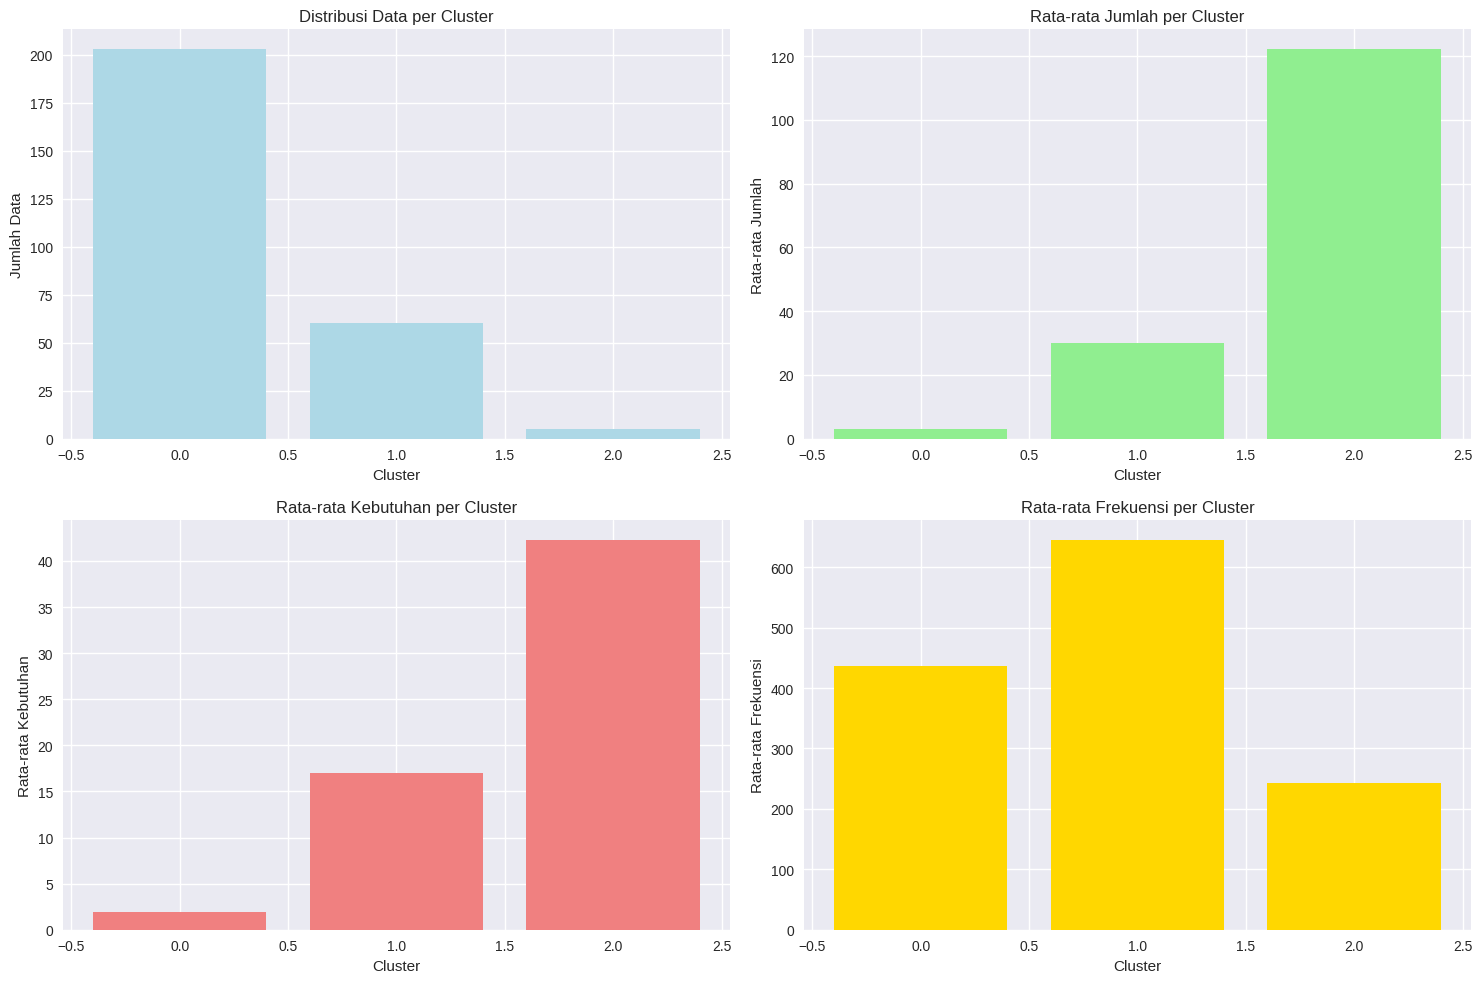

In [31]:
# Visualisasi karakteristik cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Jumlah data per cluster
cluster_counts = features_df['cluster'].value_counts().sort_index()
axes[0,0].bar(cluster_counts.index, cluster_counts.values, color='lightblue')
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_ylabel('Jumlah Data')
axes[0,0].set_title('Distribusi Data per Cluster')

# Rata-rata jumlah per cluster
avg_jumlah = features_df.groupby('cluster')['jumlah_mean'].mean()
axes[0,1].bar(avg_jumlah.index, avg_jumlah.values, color='lightgreen')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Rata-rata Jumlah')
axes[0,1].set_title('Rata-rata Jumlah per Cluster')

# Rata-rata kebutuhan per cluster
avg_kebutuhan = features_df.groupby('cluster')['kebutuhan_mean'].mean()
axes[1,0].bar(avg_kebutuhan.index, avg_kebutuhan.values, color='lightcoral')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Rata-rata Kebutuhan')
axes[1,0].set_title('Rata-rata Kebutuhan per Cluster')

# Rata-rata frekuensi per cluster
avg_frequency = features_df.groupby('cluster')['frequency'].mean()
axes[1,1].bar(avg_frequency.index, avg_frequency.values, color='gold')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Rata-rata Frekuensi')
axes[1,1].set_title('Rata-rata Frekuensi per Cluster')

plt.tight_layout()
plt.show()

In [32]:
# Evaluasi menggunakan berbagai metrik
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

print("=== EVALUASI MODEL ===")
print(f"Silhouette Score: {silhouette_score(X_scaled, clusters):.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, clusters):.3f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, clusters):.3f}")

=== EVALUASI MODEL ===
Silhouette Score: 0.714
Calinski-Harabasz Score: 404.607
Davies-Bouldin Score: 0.653


In [33]:
# Interpretasi cluster
def interpret_clusters(cluster_results):
    """
    Memberikan interpretasi bisnis untuk setiap cluster
    """
    interpretations = []

    for result in cluster_results:
        cluster_id = result['cluster_id']
        avg_jumlah = result['avg_jumlah']
        avg_kebutuhan = result['avg_kebutuhan']

        # Kategorisasi berdasarkan nilai rata-rata
        if avg_kebutuhan > 1000:
            demand_level = "Tinggi"
        elif avg_kebutuhan > 500:
            demand_level = "Sedang"
        else:
            demand_level = "Rendah"

        if avg_jumlah > avg_kebutuhan:
            stock_status = "Overstock"
        elif avg_jumlah < avg_kebutuhan * 0.8:
            stock_status = "Understock"
        else:
            stock_status = "Seimbang"

        interpretation = {
            'cluster_id': cluster_id,
            'demand_level': demand_level,
            'stock_status': stock_status,
            'recommendation': f"Cluster dengan kebutuhan {demand_level.lower()} dan status {stock_status.lower()}"
        }

        interpretations.append(interpretation)

    return interpretations

interpretations = interpret_clusters(cluster_results)

print("\n=== INTERPRETASI BISNIS ===")
for interp in interpretations:
    print(f"\nCluster {interp['cluster_id']}:")
    print(f"  - Level kebutuhan: {interp['demand_level']}")
    print(f"  - Status stok: {interp['stock_status']}")
    print(f"  - Rekomendasi: {interp['recommendation']}")


=== INTERPRETASI BISNIS ===

Cluster 0:
  - Level kebutuhan: Rendah
  - Status stok: Overstock
  - Rekomendasi: Cluster dengan kebutuhan rendah dan status overstock

Cluster 1:
  - Level kebutuhan: Rendah
  - Status stok: Overstock
  - Rekomendasi: Cluster dengan kebutuhan rendah dan status overstock

Cluster 2:
  - Level kebutuhan: Rendah
  - Status stok: Overstock
  - Rekomendasi: Cluster dengan kebutuhan rendah dan status overstock


In [34]:
import joblib

# Save model dan preprocessing objects
model_objects = {
    'kmeans_model': kmeans_optimal,
    'scaler': scaler,
    'feature_columns': X.columns.tolist(),
    'optimal_k': optimal_k,
    'cluster_centers': centers_original,
    'cluster_analysis': cluster_results,
    'interpretations': interpretations
}

# Save ke file
joblib.dump(model_objects, 'market_clustering_model.pkl')
print("Model dan preprocessing objects telah disimpan ke 'market_clustering_model.pkl'")

Model dan preprocessing objects telah disimpan ke 'market_clustering_model.pkl'


In [35]:
def predict_cluster(jumlah_mean, kebutuhan_mean, model_objects):
    """
    Fungsi untuk memprediksi cluster dari data baru

    Parameters:
    - jumlah_mean: rata-rata jumlah barang
    - kebutuhan_mean: rata-rata kebutuhan barang
    - model_objects: dictionary berisi model dan preprocessing objects

    Returns:
    - cluster_id: ID cluster yang diprediksi
    - interpretation: interpretasi cluster
    """
    # Load model components
    kmeans_model = model_objects['kmeans_model']
    scaler = model_objects['scaler']
    interpretations = model_objects['interpretations']

    # Prepare data
    new_data = np.array([[jumlah_mean, kebutuhan_mean]])
    new_data_scaled = scaler.transform(new_data)

    # Predict cluster
    cluster_id = kmeans_model.predict(new_data_scaled)[0]

    # Get interpretation
    interpretation = next((interp for interp in interpretations
                          if interp['cluster_id'] == cluster_id), None)

    return cluster_id, interpretation

# Contoh penggunaan
print("=== CONTOH INFERENSI ===")

# Test cases
test_cases = [
    (500, 600, "Stok rendah, kebutuhan sedang"),
    (1200, 1000, "Stok tinggi, kebutuhan tinggi"),
    (300, 200, "Stok sedang, kebutuhan rendah"),
    (800, 1200, "Stok sedang, kebutuhan tinggi")
]

for jumlah, kebutuhan, deskripsi in test_cases:
    cluster_id, interpretation = predict_cluster(jumlah, kebutuhan, model_objects)

    print(f"\nTest case: {deskripsi}")
    print(f"Input: Jumlah={jumlah}, Kebutuhan={kebutuhan}")
    print(f"Prediksi cluster: {cluster_id}")
    if interpretation:
        print(f"Interpretasi: {interpretation['recommendation']}")
        print(f"Level kebutuhan: {interpretation['demand_level']}")
        print(f"Status stok: {interpretation['stock_status']}")

=== CONTOH INFERENSI ===

Test case: Stok rendah, kebutuhan sedang
Input: Jumlah=500, Kebutuhan=600
Prediksi cluster: 2
Interpretasi: Cluster dengan kebutuhan rendah dan status overstock
Level kebutuhan: Rendah
Status stok: Overstock

Test case: Stok tinggi, kebutuhan tinggi
Input: Jumlah=1200, Kebutuhan=1000
Prediksi cluster: 2
Interpretasi: Cluster dengan kebutuhan rendah dan status overstock
Level kebutuhan: Rendah
Status stok: Overstock

Test case: Stok sedang, kebutuhan rendah
Input: Jumlah=300, Kebutuhan=200
Prediksi cluster: 2
Interpretasi: Cluster dengan kebutuhan rendah dan status overstock
Level kebutuhan: Rendah
Status stok: Overstock

Test case: Stok sedang, kebutuhan tinggi
Input: Jumlah=800, Kebutuhan=1200
Prediksi cluster: 2
Interpretasi: Cluster dengan kebutuhan rendah dan status overstock
Level kebutuhan: Rendah
Status stok: Overstock


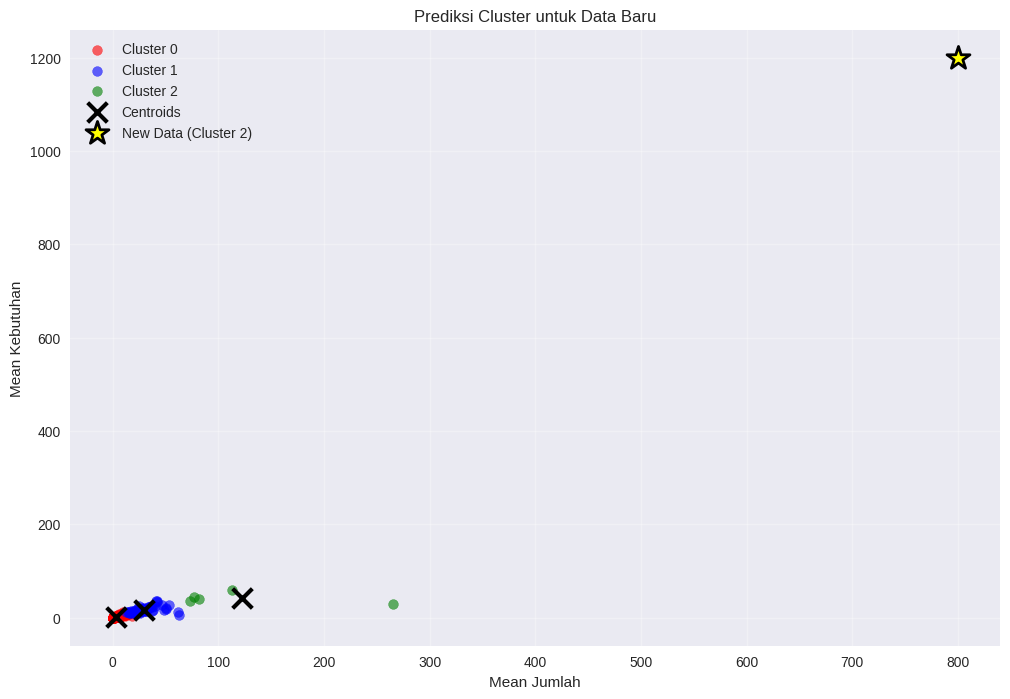

In [36]:
def visualize_prediction(jumlah_mean, kebutuhan_mean, model_objects):
    """
    Visualisasi prediksi cluster untuk data baru
    """
    cluster_id, _ = predict_cluster(jumlah_mean, kebutuhan_mean, model_objects)

    plt.figure(figsize=(12, 8))

    # Plot existing clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    for i in range(optimal_k):
        cluster_data = features_df[features_df['cluster'] == i]
        plt.scatter(cluster_data['jumlah_mean'], cluster_data['kebutuhan_mean'],
                    c=colors[i], label=f'Cluster {i}', alpha=0.6, s=50)

    # Plot cluster centers
    centers = model_objects['cluster_centers']
    plt.scatter(centers[:, 0], centers[:, 1],
                c='black', marker='x', s=200, linewidths=3, label='Centroids')

    # Plot new data point
    plt.scatter(jumlah_mean, kebutuhan_mean,
                c='yellow', marker='*', s=300, edgecolor='black', linewidth=2,
                label=f'New Data (Cluster {cluster_id})')

    plt.xlabel('Mean Jumlah')
    plt.ylabel('Mean Kebutuhan')
    plt.title(f'Prediksi Cluster untuk Data Baru')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualisasi untuk salah satu test case
visualize_prediction(800, 1200, model_objects)

In [37]:
print("=== SUMMARY ANALISIS ===")
print(f"1. Dataset original: {df.shape[0]} records")
print(f"2. Dataset setelah cleaning: {df_clean.shape[0]} records")
print(f"3. Features untuk clustering: {features_df.shape[0]} kombinasi pasar-item")
print(f"4. Jumlah cluster optimal: {optimal_k}")
print(f"5. Silhouette score: {silhouette_score(X_scaled, clusters):.3f}")

print("\n=== KARAKTERISTIK CLUSTER ===")
for i, result in enumerate(cluster_results):
    print(f"Cluster {result['cluster_id']}: {result['count']} items, "
          f"Avg Jumlah: {result['avg_jumlah']:.0f}, "
          f"Avg Kebutuhan: {result['avg_kebutuhan']:.0f}")

print("\n=== INSIGHT BISNIS ===")
print("1. Clustering berhasil mengidentifikasi pola yang berbeda dalam stok dan kebutuhan")
print("2. Setiap cluster memiliki karakteristik unik yang dapat digunakan untuk strategi inventory")
print("3. Model dapat digunakan untuk memprediksi kategori stok-kebutuhan untuk data baru")
print("4. Hasil clustering dapat membantu optimasi distribusi dan procurement")

=== SUMMARY ANALISIS ===
1. Dataset original: 269260 records
2. Dataset setelah cleaning: 128487 records
3. Features untuk clustering: 268 kombinasi pasar-item
4. Jumlah cluster optimal: 3
5. Silhouette score: 0.714

=== KARAKTERISTIK CLUSTER ===
Cluster 0: 203 items, Avg Jumlah: 3, Avg Kebutuhan: 2
Cluster 1: 60 items, Avg Jumlah: 30, Avg Kebutuhan: 17
Cluster 2: 5 items, Avg Jumlah: 122, Avg Kebutuhan: 42

=== INSIGHT BISNIS ===
1. Clustering berhasil mengidentifikasi pola yang berbeda dalam stok dan kebutuhan
2. Setiap cluster memiliki karakteristik unik yang dapat digunakan untuk strategi inventory
3. Model dapat digunakan untuk memprediksi kategori stok-kebutuhan untuk data baru
4. Hasil clustering dapat membantu optimasi distribusi dan procurement


In [38]:
# Simpan hasil analisis ke CSV
features_df.to_csv('clustering_results.csv', index=False)
pd.DataFrame(cluster_results).to_csv('cluster_analysis.csv', index=False)

print("\nHasil clustering telah disimpan ke:")
print("- clustering_results.csv")
print("- cluster_analysis.csv")
print("- market_clustering_model.pkl")


Hasil clustering telah disimpan ke:
- clustering_results.csv
- cluster_analysis.csv
- market_clustering_model.pkl


In [40]:
print("=== LANGKAH SELANJUTNYA ===")
print("1. Implementasi model dalam aplikasi Streamlit (app.py)")
print("2. Monitoring performa model secara berkala")
print("3. Update model dengan data baru")
print("4. Implementasi sistem rekomendasi berbasis cluster")

=== LANGKAH SELANJUTNYA ===
1. Implementasi model dalam aplikasi Streamlit (app.py)
2. Monitoring performa model secara berkala
3. Update model dengan data baru
4. Implementasi sistem rekomendasi berbasis cluster
